# **IMPORT DATA AND REQUIRED LIBRARIES**

In [ ]:
import os
import numpy as np
from time import time
from scipy.io import wavfile as wav

import matplotlib.pyplot as plt
import IPython.display as ipd

# Classification tools
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# File management
from google.colab import drive
import tarfile
from shutil import copyfile

In [ ]:
# Link Google Drive account, transfer dataset, and extract files
drive.mount('/content/gdrive')
copyfile('gdrive/My Drive/DIGITAL SIGNAL AND IMAGE MANAGEMENT/recordings.tar', 'recordings.tar')
tar = tarfile.open('recordings.tar')
tar.extractall()
tar.close()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Import file
sound_rate, sound_data = wav.read('recordings/0_jackson_0.wav')
# Play the signal
ipd.Audio(sound_data, rate = sound_rate)

# **DEFINE DATA LOADER AND MODEL PARAMETERS**

In [ ]:
# Placecholder for feature extractor
def identity(input):
    return input

# Data loader
def load_data(feature_extractor=identity, normalize=False):

    labels = []
    features = []

    for f in sorted(os.listdir('./recordings')):
        if f.endswith('.wav'):
            # Load file and compute the requested features
            _, signal = wav.read('./recordings/' + f)
            cur_features = feature_extractor(signal)
            features.append(cur_features)

            # Classes
            label = f.split('_')[0]
            labels.append(label)

    # X: features, y: labels
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.1, random_state=1)

    if normalize:
        eps = 0.001
        X_train = np.array(X_train)
        X_train_mean = X_train.mean(axis=0)
        X_train_std = X_train.std(axis=0)
        X_train = (X_train - X_train_mean + eps)/(X_train_std + eps)
        X_train = [row for row in X_train]

        X_test = [row for row in (np.array(X_test) - X_train_mean + eps)/(X_train_std + eps)]

    return X_train, X_test, y_train, y_test

In [ ]:
# Model's arameters to be tested in cross-validation
param_grid = {'C': [100, 500, 1000],
          'gamma': [0.005, 0.01, 0.1, 0.5, 1.0]}

# **DEFINE BASICS FEATURE EXTRACTORS BASED ON BASICS VARIATION OF ZCR**

Zero Crossing Rate (ZCR) is a common feature for digital signal analysis, based on the number of crossing of the x-axis

In [ ]:
def zero_crossing_count(input):

    crossings = np.sum(np.abs(np.diff(np.sign(input)))) // 2
    return np.array([crossings])

def zero_crossing_rate(input):

    crossings = np.sum(np.abs(np.diff(np.sign(input)))) // 2
    return np.array([crossings / len(input)])

Let's try only using the count of the crossing

In [ ]:
X_train, X_test, y_train, y_test = load_data(feature_extractor = zero_crossing_count, normalize = True)


In [ ]:
# Support Vector Machine initialization
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv = 5)

# Training
t0 = time()
clf = clf.fit(X_train, y_train)
print('Training completed in %0.3fs' % (time() - t0))

Training completed in 9.322s


The training process take a reasonable time, obviously time will increse adding features but we can consider using 5 folds for the cross validation process of parameters selection

In [ ]:
# Prediction
y_pred = clf.predict(X_test)

# Classification report
print('Classification report:')
print(classification_report(y_test, y_pred))

Classification report:
              precision    recall  f1-score   support

           0       0.31      0.47      0.37        17
           1       0.17      0.80      0.28        10
           2       0.21      0.20      0.21        15
           3       0.00      0.00      0.00        19
           4       0.00      0.00      0.00        11
           5       0.00      0.00      0.00        14
           6       0.90      0.64      0.75        14
           7       0.43      0.16      0.23        19
           8       0.29      0.24      0.26        17
           9       0.18      0.36      0.24        14

    accuracy                           0.27       150
   macro avg       0.25      0.29      0.23       150
weighted avg       0.25      0.27      0.23       150



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Confusion Matrix:


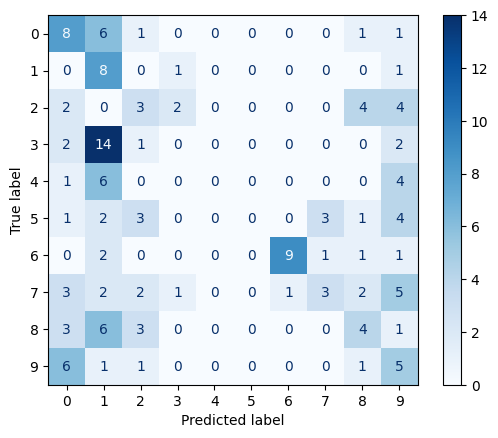

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
# Display confusion matrix
print('Confusion Matrix:')
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot(cmap = plt.cm.Blues)
plt.show()

This achieved a very low accuracy, let's try now the ZCR.
Number of crosses normalized by the length of the given signal

In [ ]:
X_train, X_test, y_train, y_test = load_data(feature_extractor = zero_crossing_rate, normalize = True)

# Support Vector Machine initialization
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv = 5)

# SVM fit
clf = clf.fit(X_train, y_train)

In [ ]:
# Prediction
y_pred = clf.predict(X_test)

# Classification report
print('Classification report:')
print(classification_report(y_test, y_pred))

Classification report:
              precision    recall  f1-score   support

           0       0.26      0.47      0.33        17
           1       0.25      0.30      0.27        10
           2       0.13      0.13      0.13        15
           3       0.00      0.00      0.00        19
           4       0.21      0.64      0.32        11
           5       0.22      0.36      0.27        14
           6       0.92      0.79      0.85        14
           7       0.00      0.00      0.00        19
           8       0.11      0.06      0.08        17
           9       0.13      0.14      0.14        14

    accuracy                           0.26       150
   macro avg       0.22      0.29      0.24       150
weighted avg       0.21      0.26      0.22       150



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Confusion Matrix:


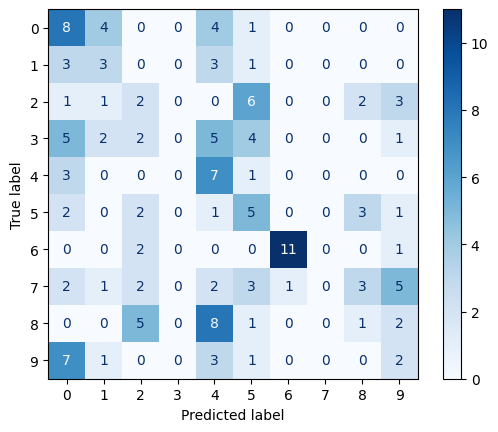

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
# Display confusion matrix
print('Confusion Matrix:')
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot(cmap = plt.cm.Blues)
plt.show()

This Achieved an even lower accuracy. Let's try to add some basics feature and combine them with ZCR

In [ ]:
def energy(input):
    return np.sum((input*1.0)**2, keepdims = True)

def duration(input):
  return np.array(input.shape)

In [ ]:
def combo1(input):
  return np.concatenate((energy(input), duration(input), zero_crossing_count(input)))

def combo2(input):
  return np.concatenate((energy(input), duration(input), zero_crossing_rate(input)))

def combo3(input):
  return np.concatenate((energy(input), duration(input), zero_crossing_count(input), zero_crossing_rate(input)))

**Energy + Duration + ZC count**

In [ ]:
# Data loading
X_train, X_test, y_train, y_test = load_data(feature_extractor = combo1, normalize = True)


In [ ]:
# Support Vector Machine initialization
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv = 5)

# Training
t0 = time()
clf = clf.fit(X_train, y_train)
print('Training completed in %0.3fs' % (time() - t0))




Training completed in 13.457s


In [ ]:
# Prediction
y_pred = clf.predict(X_test)

# Classification report
print('Classification report:')
print(classification_report(y_test, y_pred))

Classification report:
              precision    recall  f1-score   support

           0       0.71      0.59      0.65        17
           1       0.41      0.90      0.56        10
           2       0.54      0.47      0.50        15
           3       0.55      0.32      0.40        19
           4       0.42      0.45      0.43        11
           5       0.32      0.43      0.36        14
           6       0.79      0.79      0.79        14
           7       0.25      0.11      0.15        19
           8       0.44      0.47      0.46        17
           9       0.47      0.64      0.55        14

    accuracy                           0.49       150
   macro avg       0.49      0.52      0.48       150
weighted avg       0.49      0.49      0.47       150



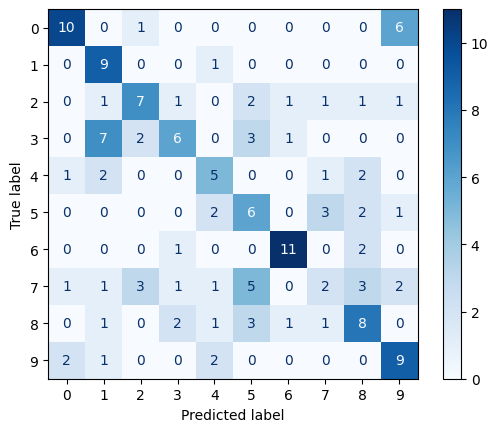

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot(cmap = plt.cm.Blues)
plt.show()

**Energy + Duration + ZCRate**

In [ ]:
# Data loading
X_train, X_test, y_train, y_test = load_data(feature_extractor = combo2, normalize = True)

# Support Vector Machine initialization
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv = 5)

# Fit SVM
clf = clf.fit(X_train, y_train)

Classification report:
              precision    recall  f1-score   support

           0       0.86      0.71      0.77        17
           1       0.42      0.80      0.55        10
           2       0.50      0.53      0.52        15
           3       0.67      0.42      0.52        19
           4       0.50      0.45      0.48        11
           5       0.30      0.43      0.35        14
           6       0.80      0.86      0.83        14
           7       0.40      0.21      0.28        19
           8       0.47      0.47      0.47        17
           9       0.65      0.79      0.71        14

    accuracy                           0.55       150
   macro avg       0.56      0.57      0.55       150
weighted avg       0.56      0.55      0.54       150

Confusion Matrix:


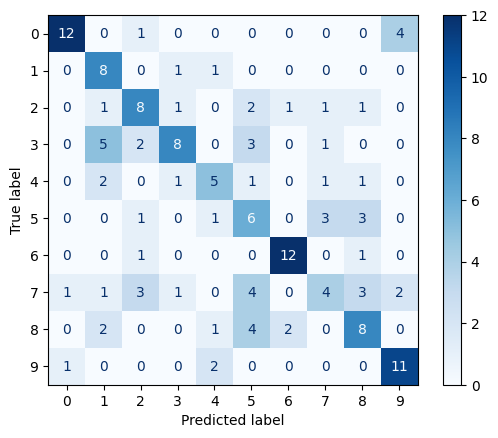

In [ ]:
# Prediction
y_pred = clf.predict(X_test)

# Classification report
print('Classification report:')
print(classification_report(y_test, y_pred))

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
# Display confusion matrix
print('Confusion Matrix:')
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot(cmap = plt.cm.Blues)
plt.show()

Combining basic features with the ZCR provided a significant increment of the accuracy; however is still relatively low. Let' see if using both version of ZCR we can improve our performance

In [ ]:
# Data loading
X_train, X_test, y_train, y_test = load_data(feature_extractor = combo3, normalize = True)

# Support Vector Machine initialization
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv = 5)

# Fit SVM
clf = clf.fit(X_train, y_train)

Classification report:
              precision    recall  f1-score   support

           0       0.81      0.76      0.79        17
           1       0.38      0.80      0.52        10
           2       0.57      0.53      0.55        15
           3       0.69      0.47      0.56        19
           4       0.50      0.55      0.52        11
           5       0.30      0.50      0.38        14
           6       0.79      0.79      0.79        14
           7       0.50      0.11      0.17        19
           8       0.42      0.47      0.44        17
           9       0.64      0.64      0.64        14

    accuracy                           0.54       150
   macro avg       0.56      0.56      0.54       150
weighted avg       0.57      0.54      0.53       150

Confusion Matrix:


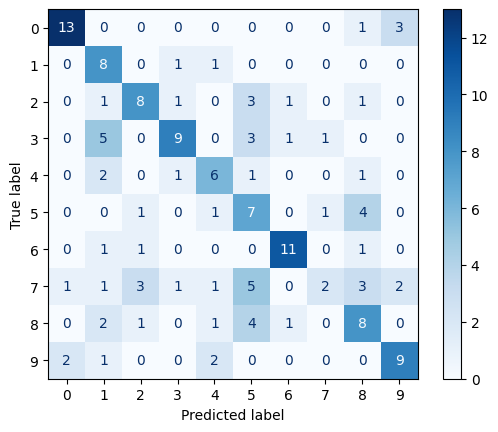

In [ ]:
# Prediction
y_pred = clf.predict(X_test)

# Classification report
print('Classification report:')
print(classification_report(y_test, y_pred))

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
# Display confusion matrix
print('Confusion Matrix:')
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot(cmap = plt.cm.Blues)
plt.show()

No significant improvement.

## **ADVANCED VARIATIONS OF ZCR**

We can imagine that previous version counts different variations that are not significant but simply noise. Let's try to implement more advanced versions that will also consider the entity of the crossing.

To do that we are going to consider the magnitude of the crossing as the **absolute variation of the zero crosses** in two different versions:
1. **normalized by signal's lenght**
2. **normalized by number of crosses**

In [ ]:
def weighted_zero_crossing_count1(input):
  magnitudes = []

  for i in range(1, len(input)):
    if (input[i] > 0 and input[i-1] < 0) or (input[i] < 0 and input[i-1] > 0):
      magnitude = np.abs(input[i] - input[i-1])
      magnitudes.append(magnitude)

  return np.array([np.mean(magnitudes)])

def weighted_zero_crossing_count2(input):
  magnitudes = []

  for i in range(1, len(input)):
    if (input[i] > 0 and input[i-1] < 0) or (input[i] < 0 and input[i-1] > 0):
      magnitude = np.abs(input[i] - input[i-1])
      magnitudes.append(magnitude)

  return np.array([np.sum(magnitudes) / len(input)])

Combine new features with previous basic features

In [ ]:
def combo4(input):
  return np.concatenate((energy(input), duration(input), weighted_zero_crossing_count1(input)))

def combo5(input):
  return np.concatenate((energy(input), duration(input), weighted_zero_crossing_count2(input)))

def combo6(input):
  return np.concatenate((energy(input), duration(input), weighted_zero_crossing_count1(input), weighted_zero_crossing_count2(input)))

def combo7(input):
  return np.concatenate((energy(input), duration(input), zero_crossing_rate(input), weighted_zero_crossing_count1(input), weighted_zero_crossing_count2(input)))

Let's try new combination
  * **energy + duration + weighted zcr normalized by n. crosses**

In [ ]:
# Data loading
X_train, X_test, y_train, y_test = load_data(feature_extractor = combo4, normalize = True)

# Support Vector Machine initialization
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv = 5)

# Fit SVM
clf = clf.fit(X_train, y_train)

<ipython-input-24-c2addad52687>:6: RuntimeWarning: overflow encountered in scalar subtract
  magnitude = np.abs(input[i] - input[i-1])


Classification report:
              precision    recall  f1-score   support

           0       0.60      0.53      0.56        17
           1       0.18      0.30      0.22        10
           2       0.54      0.47      0.50        15
           3       0.56      0.47      0.51        19
           4       0.40      0.36      0.38        11
           5       0.33      0.29      0.31        14
           6       0.50      0.71      0.59        14
           7       0.44      0.21      0.29        19
           8       0.45      0.53      0.49        17
           9       0.50      0.64      0.56        14

    accuracy                           0.45       150
   macro avg       0.45      0.45      0.44       150
weighted avg       0.47      0.45      0.45       150

Confusion Matrix:


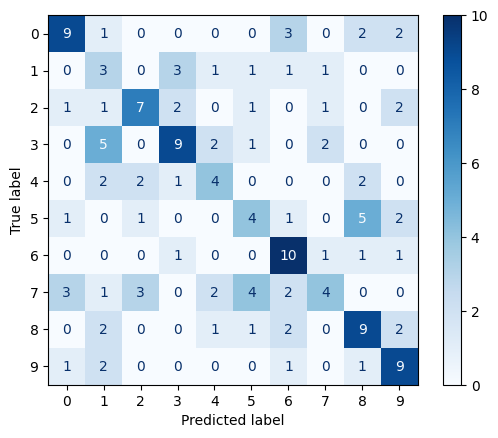

In [ ]:
# Prediction
y_pred = clf.predict(X_test)

# Classification report
print('Classification report:')
print(classification_report(y_test, y_pred))

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
# Display confusion matrix
print('Confusion Matrix:')
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot(cmap = plt.cm.Blues)
plt.show()

not good results, we do not even achieve 0.5 accuracy



*  **energy + duration + weighted zcr normalized by length of signal**




In [ ]:
# Data loading
X_train, X_test, y_train, y_test = load_data(feature_extractor = combo5, normalize = True)

# Support Vector Machine initialization
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv = 5)

# Fit SVM
clf = clf.fit(X_train, y_train)

<ipython-input-24-c2addad52687>:16: RuntimeWarning: overflow encountered in scalar subtract
  magnitude = np.abs(input[i] - input[i-1])


Classification report:
              precision    recall  f1-score   support

           0       0.67      0.59      0.62        17
           1       0.25      0.50      0.33        10
           2       0.62      0.53      0.57        15
           3       0.64      0.47      0.55        19
           4       0.36      0.36      0.36        11
           5       0.23      0.21      0.22        14
           6       0.60      0.64      0.62        14
           7       0.53      0.42      0.47        19
           8       0.33      0.35      0.34        17
           9       0.44      0.50      0.47        14

    accuracy                           0.46       150
   macro avg       0.47      0.46      0.46       150
weighted avg       0.49      0.46      0.47       150

Confusion Matrix:


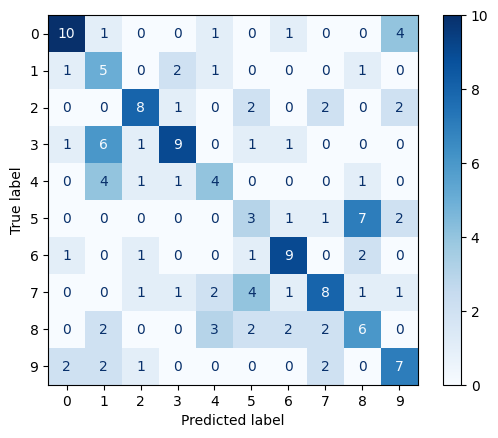

In [ ]:
# Prediction
y_pred = clf.predict(X_test)

# Classification report
print('Classification report:')
print(classification_report(y_test, y_pred))

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
# Display confusion matrix
print('Confusion Matrix:')
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot(cmap = plt.cm.Blues)
plt.show()

still no improvement

*  **energy + duration + weighted zcr normalized by length of signal + weighted zcr normalized by n. crosses**



In [ ]:
# Data loading
X_train, X_test, y_train, y_test = load_data(feature_extractor = combo6, normalize = True)

# Support Vector Machine initialization
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv = 5)

# Fit SVM
clf = clf.fit(X_train, y_train)

<ipython-input-24-c2addad52687>:6: RuntimeWarning: overflow encountered in scalar subtract
  magnitude = np.abs(input[i] - input[i-1])
<ipython-input-24-c2addad52687>:16: RuntimeWarning: overflow encountered in scalar subtract
  magnitude = np.abs(input[i] - input[i-1])


Classification report:
              precision    recall  f1-score   support

           0       0.81      0.76      0.79        17
           1       0.44      0.70      0.54        10
           2       0.78      0.47      0.58        15
           3       0.64      0.47      0.55        19
           4       0.62      0.73      0.67        11
           5       0.47      0.50      0.48        14
           6       0.56      0.64      0.60        14
           7       0.71      0.53      0.61        19
           8       0.52      0.71      0.60        17
           9       0.64      0.64      0.64        14

    accuracy                           0.61       150
   macro avg       0.62      0.62      0.61       150
weighted avg       0.63      0.61      0.61       150

Confusion Matrix:


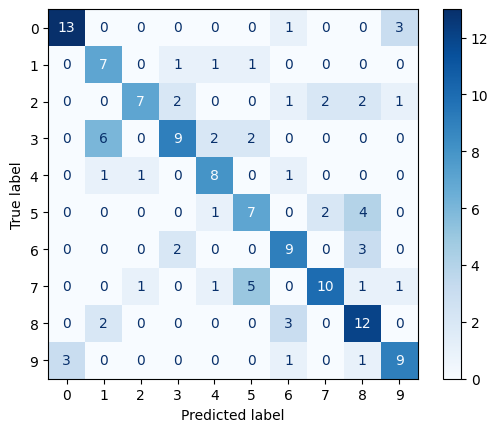

In [ ]:
# Prediction
y_pred = clf.predict(X_test)

# Classification report
print('Classification report:')
print(classification_report(y_test, y_pred))

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
# Display confusion matrix
print('Confusion Matrix:')
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot(cmap = plt.cm.Blues)
plt.show()

We finally get an improvement on the perfromance achieved with the basic zcr.
As a final attempt we try using the two weighted versions together with the zcr

In [ ]:
# Data loading
X_train, X_test, y_train, y_test = load_data(feature_extractor = combo7, normalize = True)

# Support Vector Machine initialization
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv = 5)

# Fit SVM
clf = clf.fit(X_train, y_train)

<ipython-input-24-c2addad52687>:6: RuntimeWarning: overflow encountered in scalar subtract
  magnitude = np.abs(input[i] - input[i-1])
<ipython-input-24-c2addad52687>:16: RuntimeWarning: overflow encountered in scalar subtract
  magnitude = np.abs(input[i] - input[i-1])


Classification report:
              precision    recall  f1-score   support

           0       0.86      0.71      0.77        17
           1       0.47      0.80      0.59        10
           2       0.85      0.73      0.79        15
           3       0.85      0.58      0.69        19
           4       0.50      0.73      0.59        11
           5       0.62      0.57      0.59        14
           6       0.93      0.93      0.93        14
           7       0.85      0.58      0.69        19
           8       0.67      0.71      0.69        17
           9       0.58      0.79      0.67        14

    accuracy                           0.70       150
   macro avg       0.72      0.71      0.70       150
weighted avg       0.74      0.70      0.71       150

Confusion Matrix:


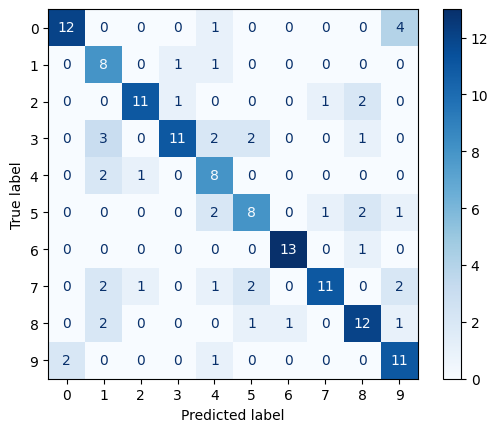

In [ ]:
# Prediction
y_pred = clf.predict(X_test)

# Classification report
print('Classification report:')
print(classification_report(y_test, y_pred))

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
# Display confusion matrix
print('Confusion Matrix:')
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot(cmap = plt.cm.Blues)
plt.show()

Confusion Matrix (normalized):


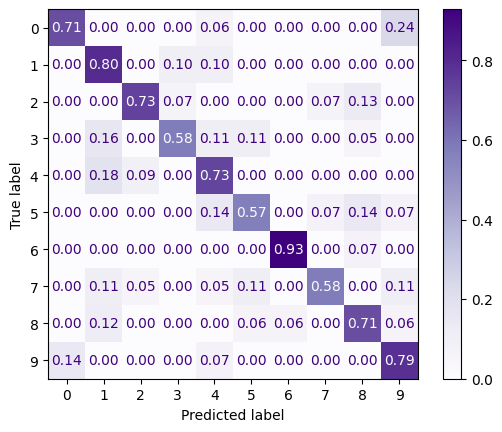

In [ ]:
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Display confusion matrix normalized by row
print('Confusion Matrix (normalized):')
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized)
disp.plot(cmap=plt.cm.Purples, values_format=".2f")  # `.2f` to round to 2nd decimal
plt.show()

With this combination of features, we achieved the best result, reaching an overall accuracy of around 70% on the Free Spoken Digit Dataset. The model demonstrates solid performance, particularly in classifying digits like 0, 6, and 8 with high reliability. However, certain classes, such as 4, 5, and 9, show higher misclassification rates, likely due to overlapping audio features or limitations in the current feature set. Considering this is a custom implementation without pre-existing libraries, the results demonstrate a good level of performance on this dataset. Enhancements could include experimenting with additional feature engineering or possibly integrating 2D features to capture more complex patterns in the spoken digit representations.